In [57]:
# import the all librbries 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mysql.connector
import numpy as np

In [15]:
# Connect to the MySQL database
dbconn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='172001',
    database='ecommerce',
    port=3306
)
cursor = dbconn.cursor()

##### 1) list all uniquies cities where cutomers are located

In [16]:
query = """ select distinct customer_city from customers """

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns=['City'])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


##### 2) Count the number of orders placed in 2017

In [17]:
query = """ select count(order_id) from  orders where order_purchase_timestamp = 2017 """

cursor.execute(query)

data = cursor.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

##### 3) Find the top 5 total sales per category

In [18]:
query = """ 
        SELECT 
            pro.product_category AS category,
            ROUND(SUM(pay.payment_value), 2) AS sales
        FROM 
            products pro
        JOIN 
            order_items oi ON pro.product_id = oi.product_id
        JOIN 
            payments pay ON oi.order_id = pay.order_id
        GROUP BY 
            pro.product_category
        ORDER BY 
            sales DESC;
        """

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df.head()

,Category,Sales
0,bed table bath,1712553.67
1,HEALTH BEAUTY,1657373.12
2,computer accessories,1585330.45
3,Furniture Decoration,1430176.39
4,Watches present,1429216.68


##### 4) Calculate the percentage of orders that were paid in installments

In [19]:
query = """ 
        SELECT 
          ROUND(100 * SUM(CASE WHEN payment_installments > 1 THEN 1 ELSE 0 END) / COUNT(*),2) AS percentage_in_installments
        FROM payments;
        """
cursor.execute(query)

data = cursor.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('49.42'))

##### 5) Count the number of customers from each state

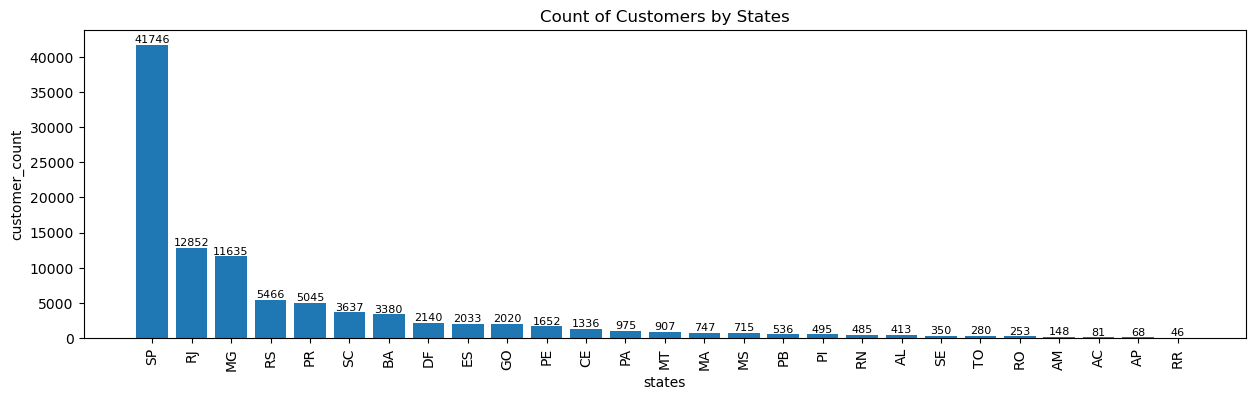

In [31]:
query = """ 
    SELECT 
        customer_state, COUNT(customer_id) AS total_customers
    FROM 
        customers
    GROUP BY 
        customer_state;
"""

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (15,4))
bars = plt.bar(df["state"], df["customer_count"])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-position (center of bar)
        height + 5,                         # y-position (just above the bar)
        str(int(height)),                  # label text
        ha='center', va='bottom', fontsize=8
    )
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

##### 6) Calculate the number of orders per month in 2018

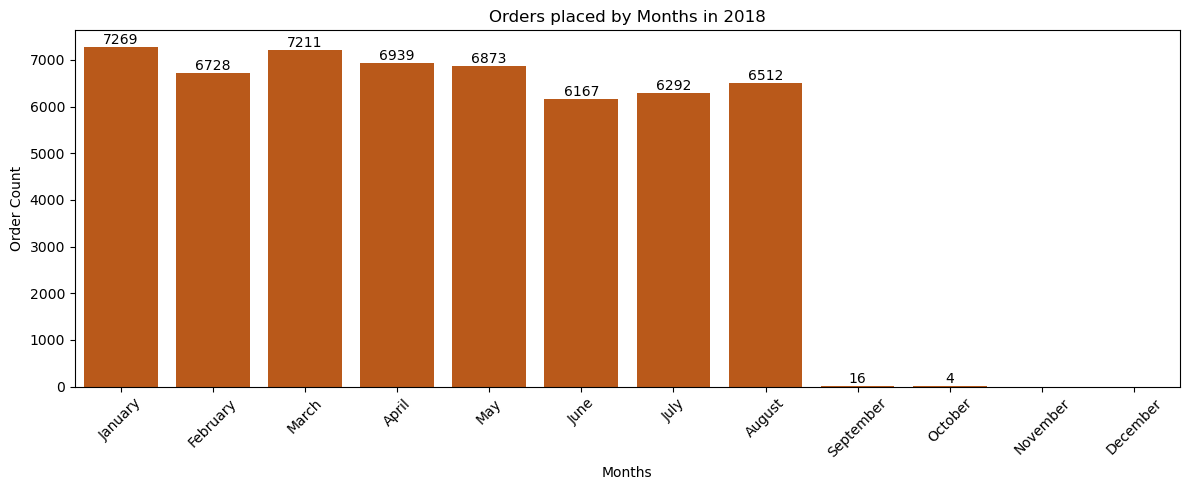

In [49]:
query = """ 
        SELECT 
            MONTHNAME(order_purchase_timestamp) AS month_name,
            COUNT(order_id) AS order_count
        FROM 
            orders 
        WHERE 
            YEAR(order_purchase_timestamp) = 2018
        GROUP BY 
            month_name
        ORDER BY 
            month_name;
"""
cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns=["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June",
     "July", "August", "September", "October", "November", "December"]

plt.figure(figsize=(12, 5)) 
ax = sns.barplot(x="months", y="order_count", data=df, order=o, color="#d35400")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Orders placed by Months in 2018")
plt.xlabel("Months")
plt.ylabel("Order Count")
plt.tight_layout()
plt.show()

##### 7) Find the average number of products per order, grouped by customer city

In [ ]:
query = """ WITH count_per_order AS (
    SELECT 
        orders.order_id, 
        orders.customer_id, 
        COUNT(order_items.order_id) AS oc
    FROM 
        orders 
    JOIN 
        order_items ON orders.order_id = order_items.order_id
    GROUP BY 
        orders.order_id, orders.customer_id
)

    SELECT 
        customers.customer_city, 
        ROUND(AVG(count_per_order.oc), 2) AS average_orders
    FROM 
        customers 
    JOIN 
        count_per_order ON customers.customer_id = count_per_order.customer_id
    GROUP BY 
        customers.customer_city 
    ORDER BY 
        average_orders DESC;
"""
cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average no of products by order"])
df.head(10)


,customer city,average no of products by order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


##### 8) Calculate the percentage of total revenue contributed by each product category

In [56]:
query= """ 
    SELECT 
        products.product_category AS category, 
        ROUND(
        (SUM(payments.payment_value) / 
         (SELECT SUM(payment_value) FROM payments)) * 100, 
        2
        ) AS sales_percentage
    FROM 
        products 
    JOIN 
        order_items ON products.product_id = order_items.product_id
    JOIN 
        payments ON payments.order_id = order_items.order_id
    GROUP BY 
        category 
    ORDER BY 
        sales_percentage DESC;
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


##### 9) Identify the correlation between product price and the number of times a product has been purchased

In [58]:
query = """ 
    SELECT 
        products.product_category, 
        COUNT(order_items.product_id),
        ROUND(AVG(order_items.price), 2)
    FROM 
        products 
    JOIN 
        order_items ON products.product_id = order_items.product_id
    GROUP BY 
        products.product_category
"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


##### 📉 Your Result: -0.1063 → Weak Negative Correlation
This means that as price increases, order count slightly decreases, but the relationship is very weak.
In simple terms: price doesn't strongly affect how often a product is ordered — at least not in this dataset.

##### 10) Calculate the total revenue generated by each seller, and rank them by revenue

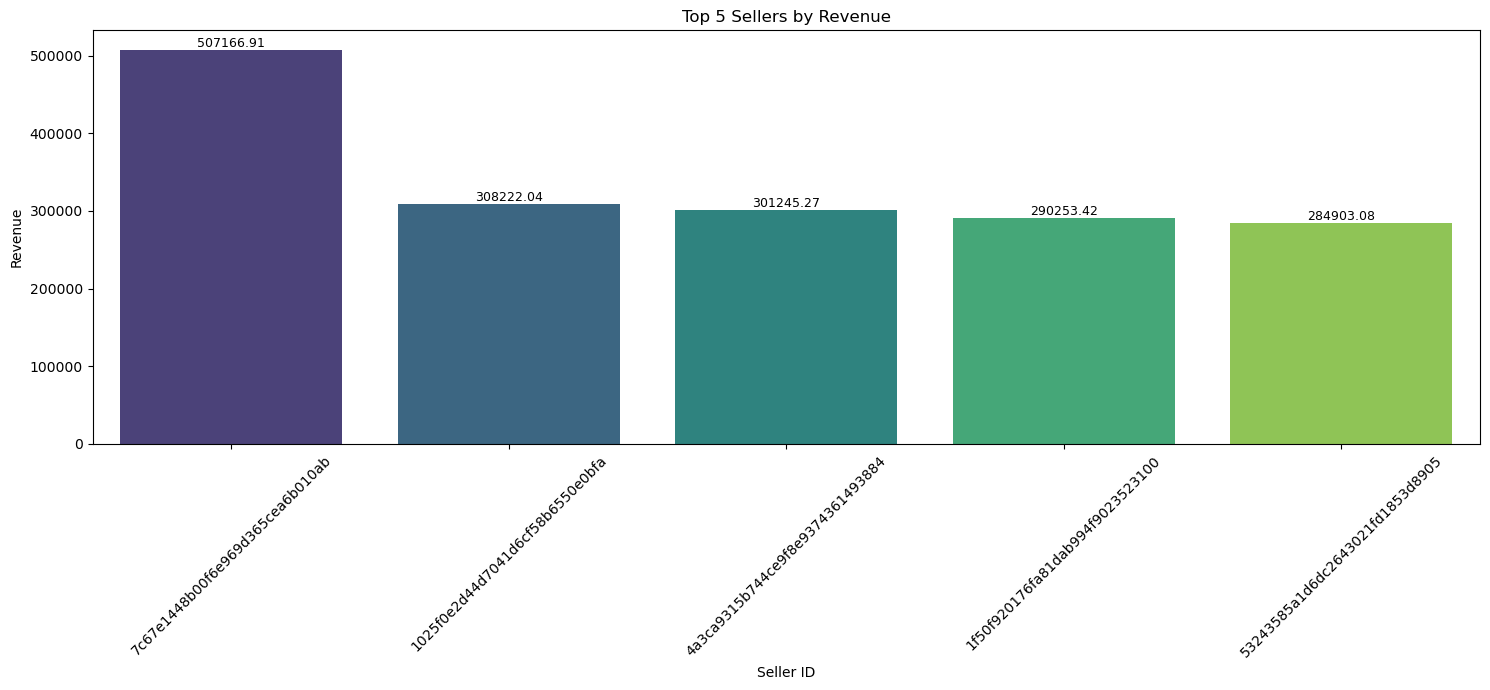

In [65]:
query = """
        SELECT *, DENSE_RANK() OVER(ORDER BY revenue DESC) AS rn
        FROM (
            SELECT order_items.seller_id, SUM(payments.payment_value) AS revenue
            FROM order_items 
        JOIN payments ON order_items.order_id = payments.order_id
        GROUP BY order_items.seller_id
        ) AS a
"""
# Execute query
cursor.execute(query)
data = cursor.fetchall()


df = pd.DataFrame(data, columns=["seller_id", "revenue", "rank"])

df = df.head()

# Create the plot
plt.figure(figsize=(15, 7))
ax = sns.barplot(x="seller_id", y="revenue", data=df, palette="viridis")
plt.title("Top 5 Sellers by Revenue")
plt.xlabel("Seller ID")
plt.ylabel("Revenue")
plt.xticks(rotation=45)

# Add data labels on bars
ax.bar_label(ax.containers[0], fmt="%.2f", fontsize=9)

plt.tight_layout()
plt.show()

##### 11) Calculate the moving average of order values for each customer over their order history

In [67]:
query = """
        SELECT 
            customer_id, 
            order_purchase_timestamp, 
            payment,
            AVG(payment) OVER (
           PARTITION BY customer_id 
           ORDER BY order_purchase_timestamp
           ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
            ) AS mov_avg
    FROM (
        SELECT orders.customer_id, orders.order_purchase_timestamp, 
           payments.payment_value AS payment
        FROM payments 
        JOIN orders ON payments.order_id = orders.order_id
    ) AS a
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["customer_id", "order_purchase_timestamp", "payment", "mov_avg"])
df.head()

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


##### 12) Calculate the cumulative sales per month for each year

In [69]:
query = """
    SELECT 
        years, 
        months, 
        payment,
        SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales 
    FROM (
        SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        MONTH(orders.order_purchase_timestamp) AS months,
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM 
        orders 
    JOIN 
        payments ON orders.order_id = payments.order_id
    GROUP BY 
        years, months 
    ORDER BY 
        years, months
    ) AS a
"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns=["Year", "Month", "Monthly_Sales", "Cumulative_Sales"])
df.head(12)  # shows the first 12 months (1 year)


,Year,Month,Monthly_Sales,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


##### 13) Calculate the year-over-year growth rate of total sales

In [ ]:
query = """
WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years 
    ORDER BY years
)

SELECT 
    years, 
    ROUND(
        ((payment - LAG(payment, 1) OVER (ORDER BY years)) / 
        LAG(payment, 1) OVER (ORDER BY years)) * 100, 
    2) AS yoy_growth_percent
FROM a
"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns=["Year", "YoY % Growth"])
df


,Year,YoY % Growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


##### 14) Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [72]:
query = """
WITH a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM 
        customers
    JOIN 
        orders ON customers.customer_id = orders.customer_id
    GROUP BY 
        customers.customer_id
),


b AS (
    SELECT a.customer_id,
           COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a
    JOIN 
        orders ON orders.customer_id = a.customer_id
    WHERE 
        orders.order_purchase_timestamp > first_order AND orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
    GROUP BY 
        a.customer_id
)

SELECT 
    100 * COUNT(DISTINCT b.customer_id) / COUNT(DISTINCT a.customer_id) AS retention_rate
FROM a
LEFT JOIN b ON a.customer_id = b.customer_id;
"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["Retention Rate (%)"])
print(df)



  Retention Rate (%)
0             0.0000


📉 0% Retention Rate
- None of the customers placed a second order within 6 months of their first purchase.

##### 15) Identify the top 3 customers who spent the most money in each year

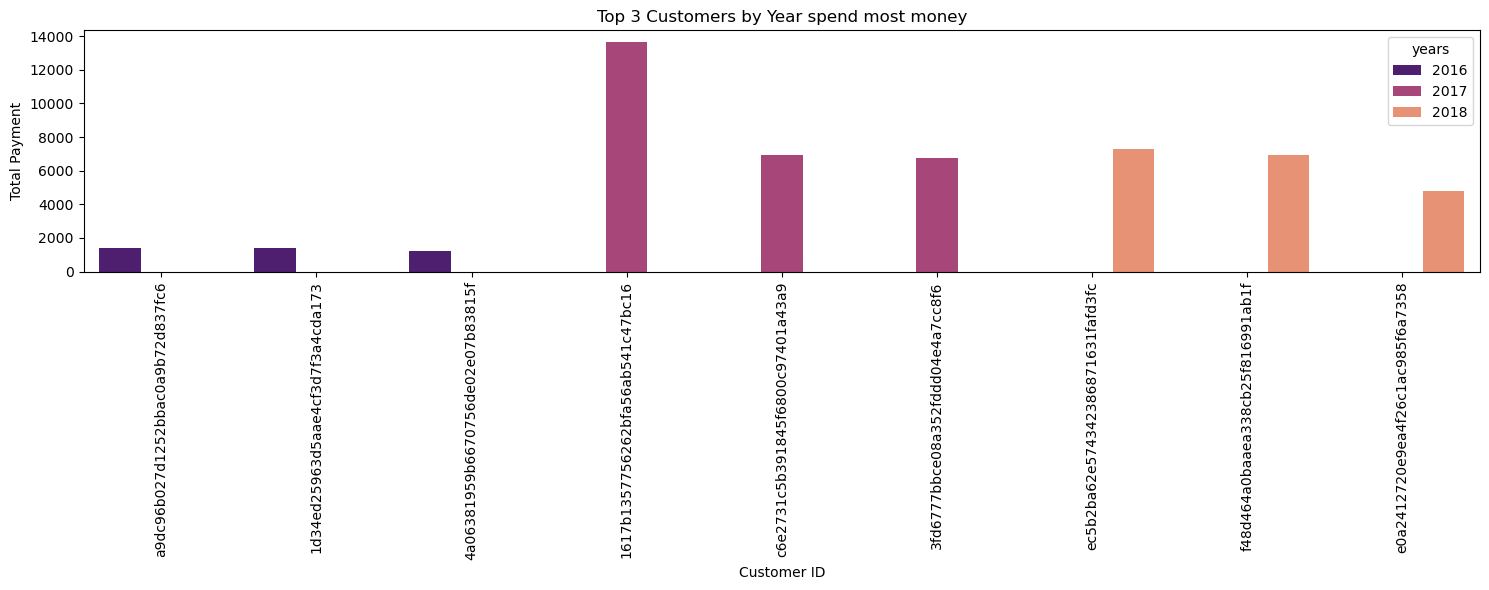

In [93]:

query = """
        SELECT 
            years, customer_id, payment, d_rank
        FROM (
            SELECT 
            YEAR(orders.order_purchase_timestamp) AS years,
            orders.customer_id,
            SUM(payments.payment_value) AS payment,
            DENSE_RANK() OVER(
            PARTITION BY YEAR(orders.order_purchase_timestamp)
            ORDER BY SUM(payments.payment_value) DESC
            ) AS d_rank
        FROM 
            orders
        JOIN 
            payments ON payments.order_id = orders.order_id
        GROUP BY 
            YEAR(orders.order_purchase_timestamp), orders.customer_id
        ) AS a
        WHERE 
            d_rank <= 3;
"""

cursor.execute(query)
data = cursor.fetchall()


df = pd.DataFrame(data, columns=["years", "id", "payment", "rank"])

# ✅ Convert year to string for legend
df["years"] = df["years"].astype(str)


plt.figure(figsize=(15,6))
sns.barplot(x="id", y="payment", hue="years", data=df, palette="magma")

plt.xticks(rotation=90)
plt.xlabel("Customer ID")
plt.ylabel("Total Payment")
plt.title("Top 3 Customers by Year spend most money")
plt.tight_layout()
plt.show()
